Item-Item Filtering Recommendations for Existing User 1:


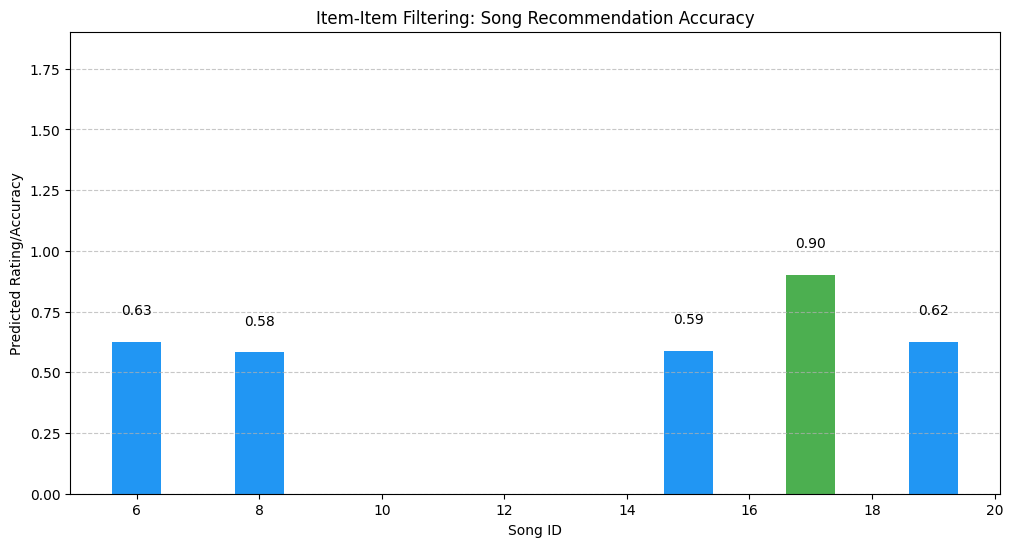

User-User Filtering Recommendations for New User (Based on Preferences):


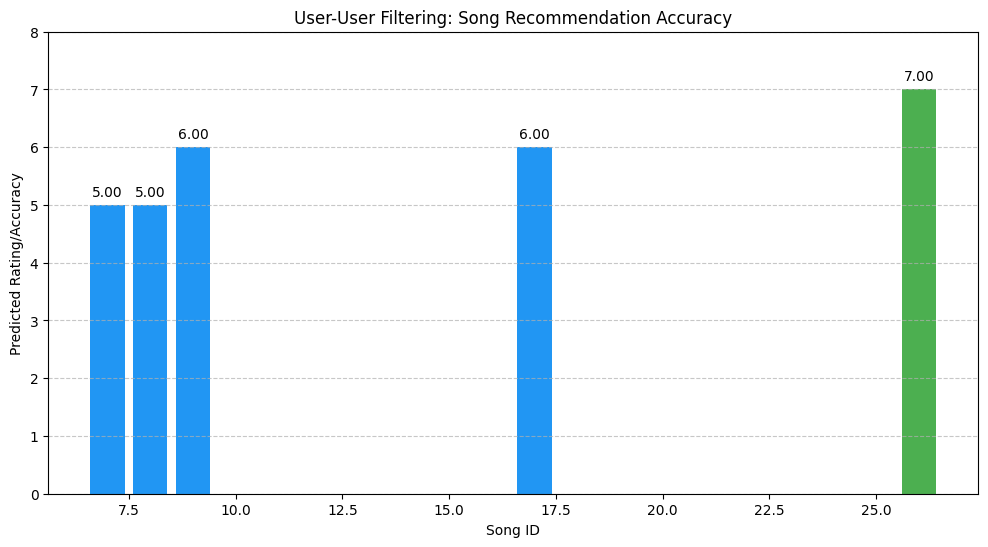

Item-Item Filtering Recommendations (Existing User):
17    0.902443
6     0.625021
19    0.624695
15    0.588148
8     0.582482
dtype: float64

User-User Filtering Recommendations (New User):
26    7.0
9     6.0
17    6.0
7     5.0
8     5.0
dtype: float64


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


data = {
    'user_id': np.random.choice(range(1, 101), 1000),
    'song_id': np.random.choice(range(1, 51), 1000),
    'rating': np.random.randint(1, 6, size=1000)
}
df = pd.DataFrame(data)


user_item_matrix = df.pivot_table(index='user_id', columns='song_id', values='rating').fillna(0)


def get_user_user_recommendations_for_new_user(preferences):
    similar_users = user_item_matrix.loc[:, preferences].mean(axis=1)
    similar_users = similar_users.nlargest(3).index.tolist()

    recommendations = pd.Series(dtype=float)
    for user in similar_users:
        user_ratings = user_item_matrix.loc[user]
        for song_id in user_ratings.index:
            if song_id not in preferences:
                recommendations[song_id] = recommendations.get(song_id, 0) + user_ratings[song_id]

    return recommendations.nlargest(5)


def get_item_item_recommendations_for_existing_user(user_id):
    song_similarity = cosine_similarity(user_item_matrix.T)
    song_similarity_df = pd.DataFrame(song_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

    user_ratings = user_item_matrix.loc[user_id]
    rated_songs = user_ratings[user_ratings > 0].index.tolist()

    recommendations = pd.Series(dtype=float)
    for song in rated_songs:
        similar_songs = song_similarity_df[song].nlargest(5).index.tolist()
        for similar_song in similar_songs:
            if user_item_matrix.loc[user_id, similar_song] == 0:
                score = song_similarity_df[song][similar_song]
                recommendations[similar_song] = recommendations.get(similar_song, 0) + score

    if recommendations.empty:
        avg_ratings = df.groupby('song_id')['rating'].mean().sort_values(ascending=False)
        return avg_ratings.nlargest(5)

    return recommendations.nlargest(5)


def plot_song_accuracy_comparisons(recommendations, title):
    songs = list(recommendations.index)
    song_scores = [recommendations[song] for song in songs]

    plt.figure(figsize=(12, 6))

    colors = ['#2196F3' if score != max(song_scores) else '#4CAF50' for score in song_scores]  # Highlight the recommended song


    plt.bar(songs, song_scores, color=colors)


    for i, score in enumerate(song_scores):
        plt.text(songs[i], score + 0.1, f'{score:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(title)
    plt.xlabel('Song ID')
    plt.ylabel('Predicted Rating/Accuracy')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, max(song_scores) + 1)  # Set y-axis limit to leave space for labels
    plt.show()


def recommend_songs(user_id=None, preferences=None):
    if user_id is None and preferences is not None:
        print("User-User Filtering Recommendations for New User (Based on Preferences):")
        recommendations = get_user_user_recommendations_for_new_user(preferences)
        plot_song_accuracy_comparisons(recommendations, 'User-User Filtering: Song Recommendation Accuracy')
        return recommendations
    elif user_id is not None:
        print(f"Item-Item Filtering Recommendations for Existing User {user_id}:")
        recommendations = get_item_item_recommendations_for_existing_user(user_id)
        plot_song_accuracy_comparisons(recommendations, 'Item-Item Filtering: Song Recommendation Accuracy')
        return recommendations
    else:
        print("Invalid input: Please provide either a user_id or preferences for a new user.")


existing_user = 1
new_user_preferences = [1, 2, 3]


item_item_recommendations = recommend_songs(user_id=existing_user)


user_user_recommendations = recommend_songs(preferences=new_user_preferences)


print("Item-Item Filtering Recommendations (Existing User):")
print(item_item_recommendations)

print("\nUser-User Filtering Recommendations (New User):")
print(user_user_recommendations)
